In [1]:
date()
mustInstall <- FALSE # Whether to install packages.
myData <- read.csv(file=file.path(".", "myData.tVaccMi.csv"))
myData$FIPS <- as.factor(myData$FIPS) # Beware: these are not all 5 digits as 0 prefix is missing after reading for some.
myData$SVI_CTGY <- as.factor(myData$SVI_CTGY) # Severity Index category

[1] "Sun May 22 11:48:03 2022"

In [2]:
str(myData)

'data.frame':	3284 obs. of  6 variables:
 $ Date            : chr  "2022-05-14" "2022-05-14" "2022-05-14" "2022-05-14" ...
 $ FIPS            : Factor w/ 3213 levels "1001","1003",..: 3084 18 154 159 181 208 246 357 396 533 ...
 $ Completeness_pct: num  96.8 92.5 90.5 90.5 97.6 97.6 97.1 98.7 89.4 89.4 ...
 $ SVI_CTGY        : Factor w/ 5 levels "","A","B","C",..: 2 5 4 5 3 4 2 3 5 5 ...
 $ Census2019      : int  89221 12067 8986 17782 1671329 137744 20356 74228 79608 7855 ...
 $ tVaccMi         : num  396 492 602 469 1958 ...


In [3]:
summary(myData)

     Date                FIPS      Completeness_pct SVI_CTGY   Census2019      
 Length:3284        1001   :   1   Min.   :73.50     : 65    Min.   :      86  
 Class :character   1003   :   1   1st Qu.:93.60    A:806    1st Qu.:   11131  
 Mode  :character   1005   :   1   Median :96.80    B:804    Median :   26108  
                    1007   :   1   Mean   :94.86    C:804    Mean   :  102950  
                    1009   :   1   3rd Qu.:97.80    D:805    3rd Qu.:   67215  
                    (Other):3208   Max.   :98.90             Max.   :10039107  
                    NA's   :  71   NA's   :23                NA's   :63        
    tVaccMi      
 Min.   : 172.6  
 1st Qu.: 403.1  
 Median : 580.9  
 Mean   : 729.5  
 3rd Qu.: 877.7  
 Max.   :4433.4  
 NA's   :75      

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
     1.86    383.23   1004.40   4214.77   2927.94 240981.72        79 

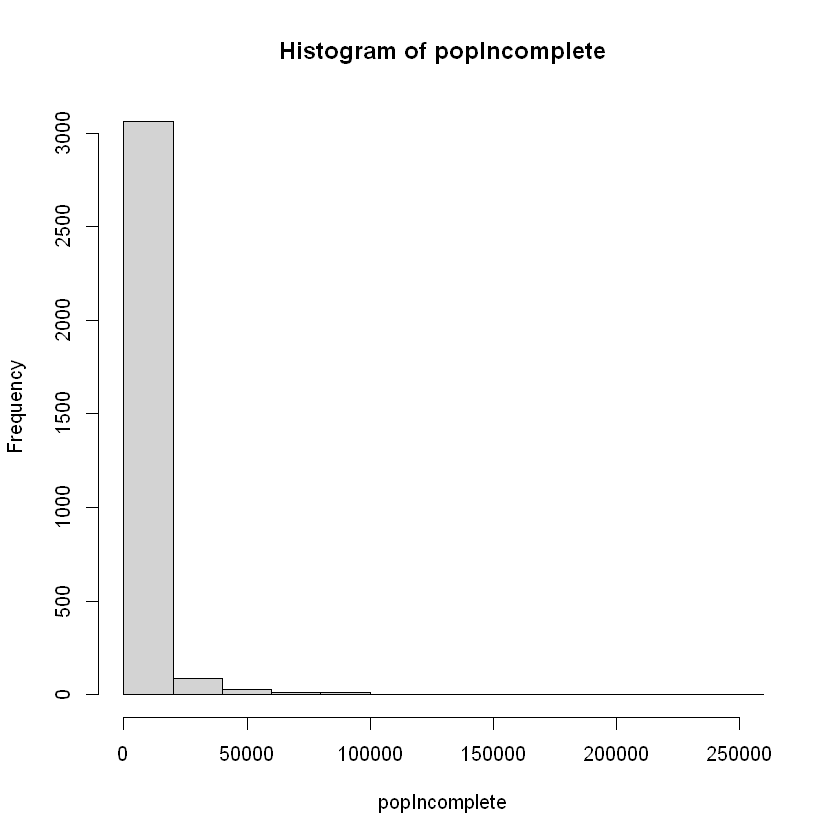

In [4]:
popIncomplete <- ((100 - myData$Completeness_pct)/100 * myData$Census2019)
# popIncomplete <- round(popIncomplete)
summary(popIncomplete); hist(popIncomplete)

In [5]:
myData.bak <- myData
myData <- cbind(myData, popIncomplete=popIncomplete)

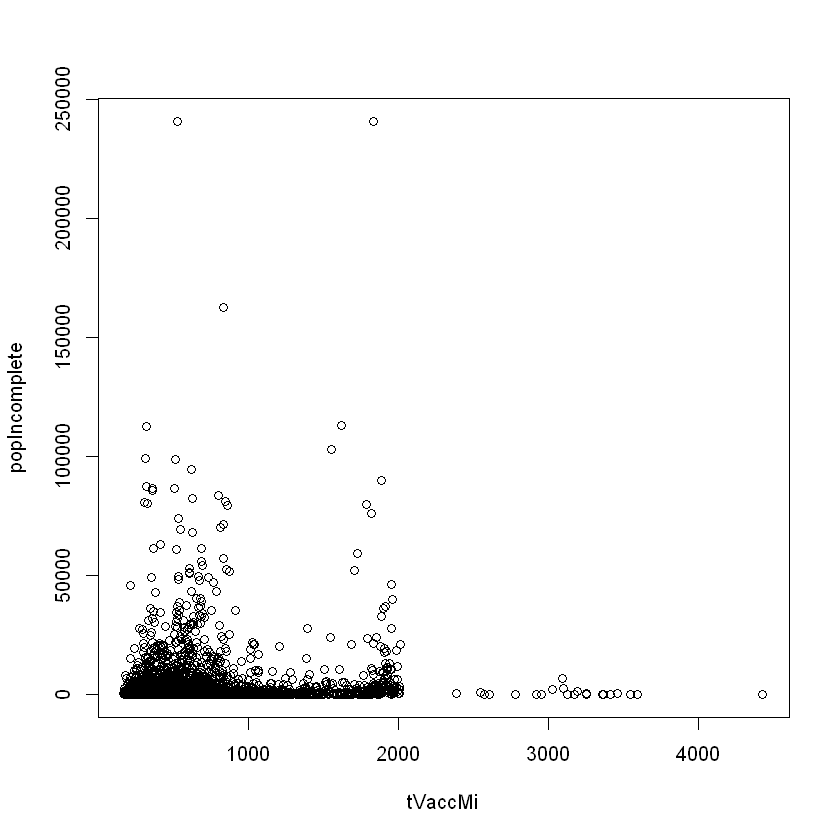

In [6]:
# As per the note at the start of "optVaccine" PDF, country administration might like to allocate more vaccines
# to counties with more `popIncomplete`. But it also wishes to minimize "cost" indicated by surrogate
# variable `tVaccMi`. To visualize how these dual Objectives interact:
plot(popIncomplete ~ tVaccMi, data=myData)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




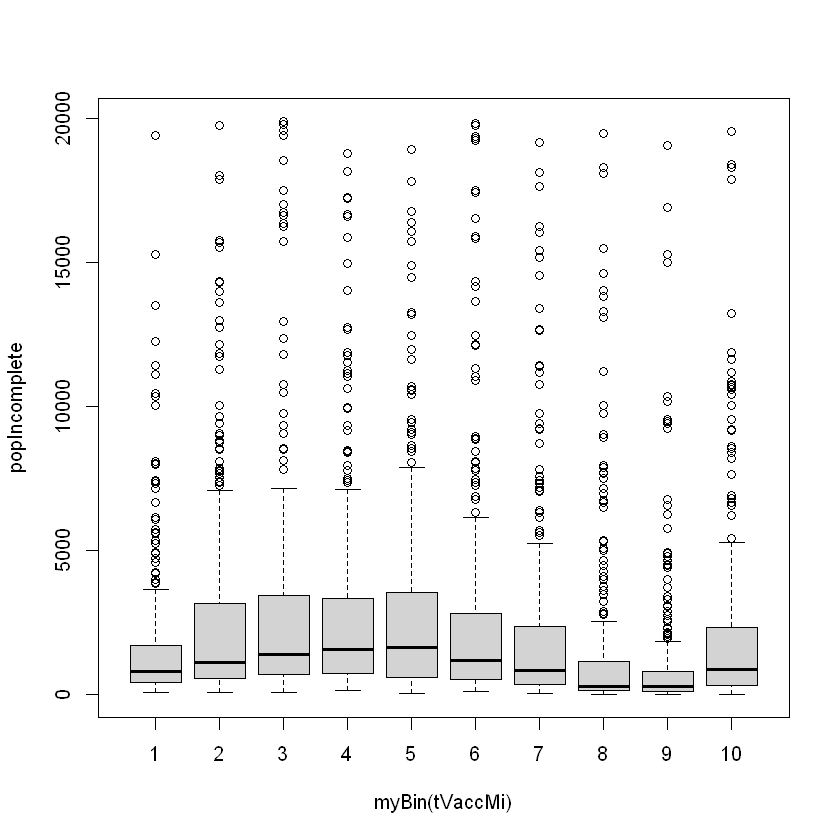

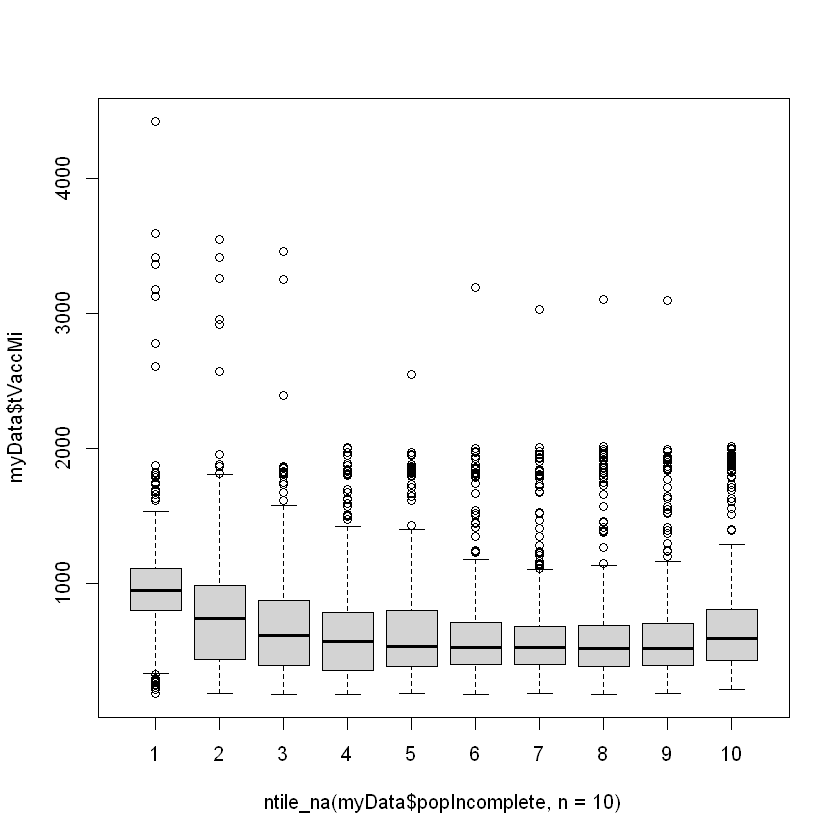

In [7]:
# Trivially, the scatter-plot points in the right half are "costly" and do not cover much vaccine-pending population.
# Counties around 500mi(les from vaccine-manufacturing states) appear to have higher `popIncomplete`; that "maxima"
# is where "optimal" might be located. There's another "hump" to the right around 2000 `tVaccMi` (miles); that seems to
# a lesser local "maxima" and the earlier one might be the "global maxima". The optimization solver must be able to
# distinguish and select the "global maxima" (or minima), not greedily locate the nearest (local) maxima.
# Refer https://stackoverflow.com/questions/41653562/difference-between-ntile-and-cut-and-then-quantile-function-in-r
require(dplyr)
myBin <- function(vector){
    ans <- as.numeric(cut(vector, 
               breaks = quantile(vector, 
                                 probs = seq(0, 1, length = 11), 
                                 na.rm = TRUE,
                                 type = 2),
               include.lowest = TRUE))
    return(ans)
}
ntile_na <- function(x,n){
  notna <- !is.na(x)
  out <- rep(NA_real_,length(x))
  out[notna] <- ntile(x[notna],n)
  return(out)
}
# boxplot((myData$popIncomplete) ~ myBin(myData$tVaccMi)) # boxplots are hardly visible coz many high outliers.
boxplot(popIncomplete ~ myBin(tVaccMi), data=myData[myData$popIncomplete <= 20000,]) # shows an expected double hump.
boxplot(myData$tVaccMi ~ ntile_na(myData$popIncomplete, n=10))

In [8]:
myData.noNA <- na.omit(myData)
if(mustInstall){ # if uninstalled
    install.packages("DEoptim")
} # else continue
require(DEoptim) # Differential-Evolution optimization. https://cran.r-project.org/web/packages/DEoptim/DEoptim.pdf
minusXbyY.vec <- function(xVec, yVec){
    return(- xVec / yVec)
}
f.popIncomplete.per.tVaccMi <- function(vec){
    popIncomplete <- vec[1]; tVaccMi <- vec[2]
    ans <- minusXbyY.vec(popIncomplete, tVaccMi)
        # Was: ans <- - (popIncomplete / tVaccMi)
        # - coz minimzed via optimization.
    return(ans)
}
myGOF.DEoptim <- function(outDEoptim){
    ## print output information
    summary(outDEoptim)
    ## plot the best members
    plot(outDEoptim, type = 'b')
    ## plot the best values
    # dev.new() # if from command-line console
    plot(outDEoptim, plot.type = "bestvalit", type = 'b', col = 'blue')
    return()
}

Loading required package: DEoptim

Loading required package: parallel


DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich




In [9]:
str(myData.noNA); length(unique(myData.noNA$FIPS))
# duplicated(myData.noNA$FIPS)

'data.frame':	3194 obs. of  7 variables:
 $ Date            : chr  "2022-05-14" "2022-05-14" "2022-05-14" "2022-05-14" ...
 $ FIPS            : Factor w/ 3213 levels "1001","1003",..: 3084 18 154 159 181 208 246 357 396 533 ...
 $ Completeness_pct: num  96.8 92.5 90.5 90.5 97.6 97.6 97.1 98.7 89.4 89.4 ...
 $ SVI_CTGY        : Factor w/ 5 levels "","A","B","C",..: 2 5 4 5 3 4 2 3 5 5 ...
 $ Census2019      : int  89221 12067 8986 17782 1671329 137744 20356 74228 79608 7855 ...
 $ tVaccMi         : num  396 492 602 469 1958 ...
 $ popIncomplete   : num  2855 905 854 1689 40112 ...
 - attr(*, "na.action")= 'omit' Named int [1:90] 34 79 116 149 183 195 226 347 351 514 ...
  ..- attr(*, "names")= chr [1:90] "34" "79" "116" "149" ...


[1] 3194

In [10]:
lower <- c(1, 1) # Alt: c(0, min(myData$tVaccMi))
upper <- c(max(myData.noNA$popIncomplete), max(myData.noNA$tVaccMi))
set.seed(1234) # for reproducibility
outDEoptim <- DEoptim(f.popIncomplete.per.tVaccMi, lower, upper) # Beware: this minimizes Objective.

Iteration: 1 bestvalit: -844.735043 bestmemit:150223.426688  177.834965
Iteration: 2 bestvalit: -3775.704014 bestmemit:216191.213182   57.258517
Iteration: 3 bestvalit: -30138.411267 bestmemit:214181.857896    7.106607
Iteration: 4 bestvalit: -30138.411267 bestmemit:214181.857896    7.106607
Iteration: 5 bestvalit: -30138.411267 bestmemit:214181.857896    7.106607
Iteration: 6 bestvalit: -30138.411267 bestmemit:214181.857896    7.106607
Iteration: 7 bestvalit: -50102.217457 bestmemit:177311.411825    3.538993
Iteration: 8 bestvalit: -114600.036670 bestmemit:177159.620120    1.545895
Iteration: 9 bestvalit: -114600.036670 bestmemit:177159.620120    1.545895
Iteration: 10 bestvalit: -146880.508909 bestmemit:227061.839746    1.545895
Iteration: 11 bestvalit: -146880.508909 bestmemit:227061.839746    1.545895
Iteration: 12 bestvalit: -146880.508909 bestmemit:227061.839746    1.545895
Iteration: 13 bestvalit: -146880.508909 bestmemit:227061.839746    1.545895
Iteration: 14 bestvalit: -16791


***** summary of DEoptim object ***** 
best member   :  240981.7 1 
best value    :  -240981.7 
after         :  200 generations 
fn evaluated  :  402 times 
*************************************


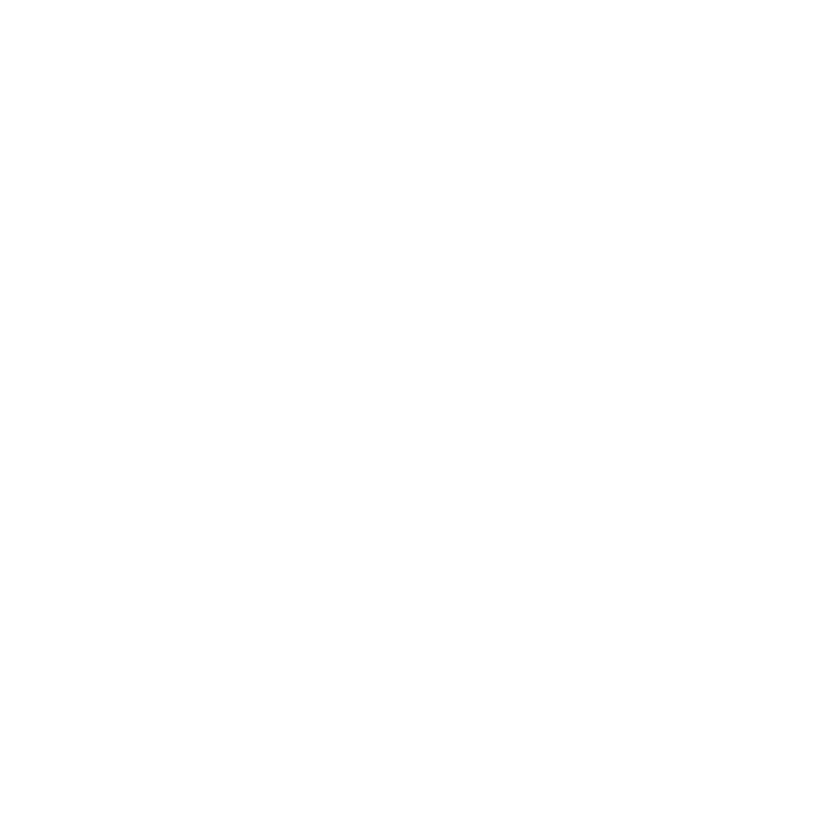

NULL

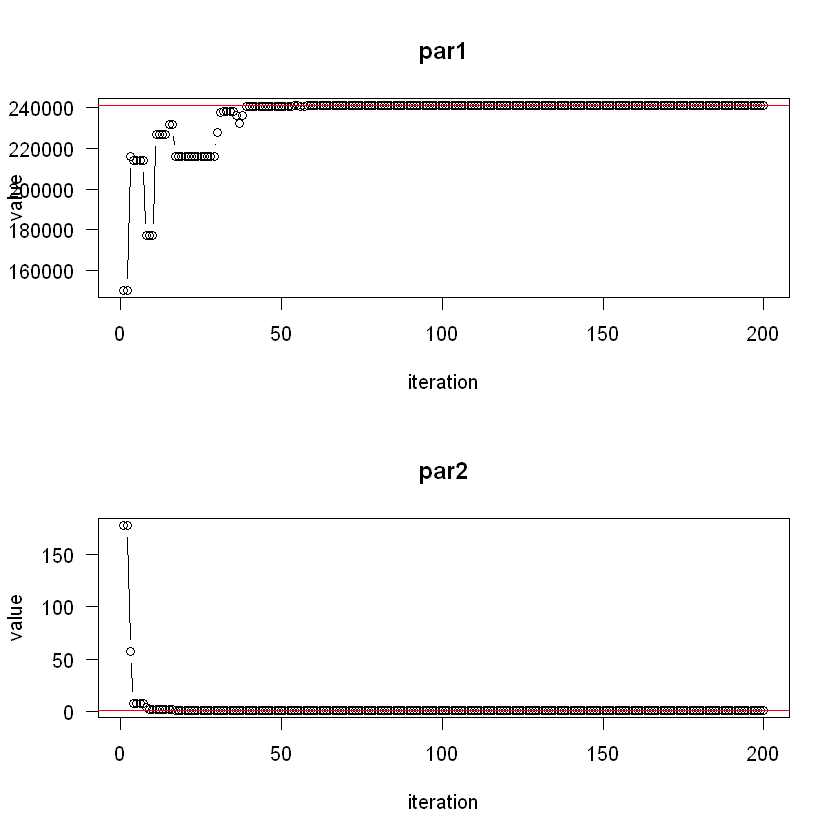

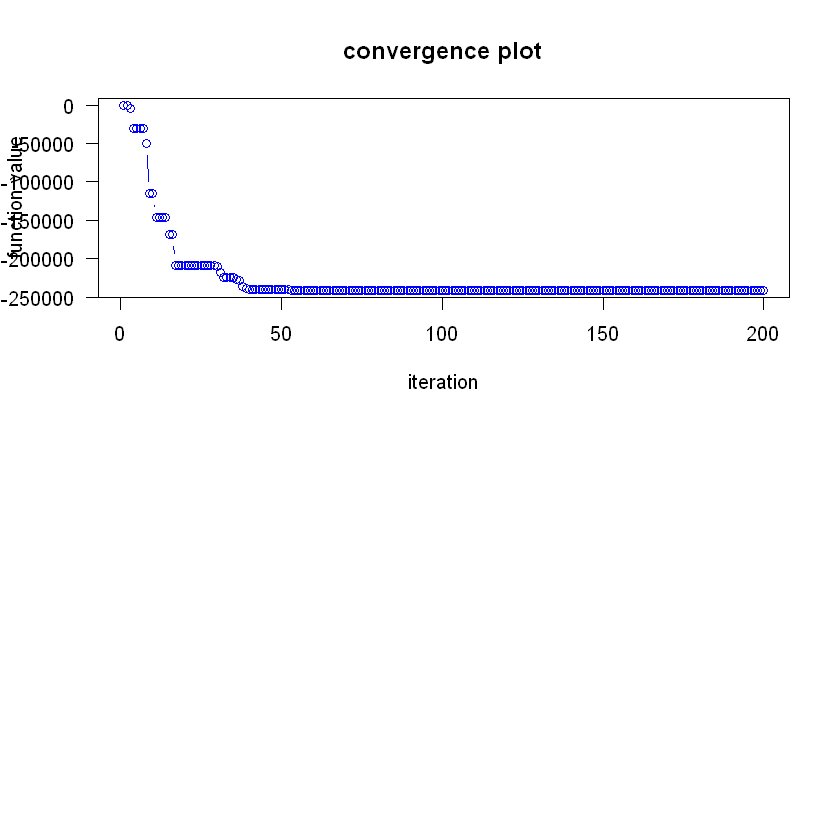

In [11]:
myGOF.DEoptim(outDEoptim)

In [12]:
# Refer https://github.com/florianhartig/DHARMa/issues/166:
if(mustInstall){
    system("sudo apt-get install libglpk-dev", intern=TRUE) # for Linux.
}

In [13]:
Sys.setenv(ROI_LOAD_PLUGINS = "FALSE")
if(mustInstall){
    install.packages(c("ROI", "ROI.plugin.glpk", "ROI.plugin.qpoases", "ROI.plugin.ecos", "ROI.plugin.scs",
                     "ROI.plugin.alabama", "ROI.plugin.lpsolve",
                     "ROI.plugin.deoptim", "ROI.plugin.ipop", "ROI.plugin.symphony")) # , "ROI.plugin.gurobi")
    install.packages("remotes")
    # https://www.gurobi.com/downloads/gurobi-optimizer-eula/ expects login. Then install gurobi and R.
    # Then its ROI plugin:
    # remotes:::install_github("roigrp/ROI.plugin.gurobi")
    # remotes:::install_github("fl0sch/ROI.plugin.gurobi") # fails presently, maybe coz R4.2?
    # install.packages("Rdonlp2")
    # https://cran.r-project.org/package=ROI.plugin.cplex says CPLEX is a commercial solver. MOSEK, Gurobi, etc., too.
    # https://github.com/cran/ROI/blob/master/R/plugin_nlminb.R includes nlminb2()
    #   [Nonlinear programming with nonlinear constraints].
} # else continue.
# Alt: via R packages rneos and ROI.plugin.neos, [Network-enabled optimization system (NEOS) ...
# The NEOS server (https://neos-server.org) provides free access to more than 60 numerical optimization solvers.]

In [14]:
library(ROI)
library(ROI.plugin.glpk)
library(ROI.plugin.qpoases)
library(ROI.plugin.ecos)
library(ROI.plugin.scs)
library(ROI.plugin.alabama)
library(ROI.plugin.lpsolve)
library(ROI.plugin.deoptim)
library(ROI.plugin.ipop)
library(ROI.plugin.symphony)
# library(ROI.plugin.gurobi)
# require(Rdonlp2) # [DONLP2 can be used freely for any kind of research purposes, otherwise it requires licensing],
#     # says https://cran.r-project.org/web/views/Optimization.html.

ROI: R Optimization Infrastructure

Registered solver plugins: nlminb.

Default solver: auto.



In [15]:
# But the above "optimal" is allocating all vaccines to one county! That's unlikely to be acceptable as equitable by
# the administration. So, a vector of county-wise weights is being sought that is optimal, i.e., as per a
# (country-level) weighted-aggregate Objective function (rather than a county-wise Objective).
f.agg.popIncomplete.per.tVaccMi <- function(vec, dat=myData.noNA){
    # Can include various constraints if used with DEoptim() and not with many other solvers.
    popIncomplete <- sum(vec * dat$popIncomplete); tVaccMi <- sum(vec * dat$tVaccMi)
        # Alt: crossprod() on vectors, or more generally, %*% for matrix multiplication.
    ans <- - (popIncomplete / tVaccMi) # - coz minimzed via optimization.
    return(ans)
}

In [16]:
c.maxWt.county <- c(0.1, 0.3, 0.7, 0.9)[1] # no county must be allocated over this (of the aggregated vaccines to be allocated).
# We might need to incorporate a min and max for c.sumWt too so that allocations completely consume manufactured vaccines.
nCounties <- length(unique(myData.noNA$FIPS)); stopifnot(nCounties == nrow(myData.noNA))
nCounties <- min(c(3, 30, 300, 3200)[4], nrow(myData.noNA))
lower <- rep(0, times=nCounties) # -ve weights are unacceptable. Beware: it overwrites earlier `lower`!
upper <- rep(c.maxWt.county, times=nCounties)
set.seed(1234) # for reproducibility
if(FALSE){ # avoid running DEoptim() unless you've worked out its timely completion.
    outDEoptim <- DEoptim(f.agg.popIncomplete.per.tVaccMi, lower, upper) # Beware: this minimizes Objective.
    myGOF.DEoptim(outDEoptim)
} # else continue.

In [32]:
f.wtSum.n <- function(vec, nConstraints=2){
    vec.sum <- sum(vec)
    vec.sum.n <- rep(vec.sum, times=nConstraints)
    return(vec.sum.n)
}
my.ROI_solve <- function(solv.app.i, op2, dat, dat.n, relaxBoundsForWhichSolvers, controlForWhichSolvers, verbose=FALSE){
    print(paste("Starting:", solv.app.i))
    rep1.n <- rep(1, times=dat.n)
    op2.use <- op2
    if(solv.app.i %in% relaxBoundsForWhichSolvers){
        print("Relaxing bounds.")
        constraints(op2.use) <- L_constraint(L=rbind(rep1.n, rep1.n), dir=c(">=", "<="),
                                             rhs = c(1 - myPrecision, 1 + myPrecision),
                                             names=as.character(dat$FIPS)[1:dat.n])
    } # else continue.
    ans <- ROI_solve(op2.use, solver=solv.app.i,
                     control=if(solv.app.i %in% controlForWhichSolvers){
                                print("Including control=list(start=...)")
                                list(start=start2, tol=myPrecision, verbose=verbose)
                            } else {
                                list(verbose=verbose)
                            }
                    )
        # Was till 2022May20: control=list(start=start2), tol=myPrecision
        # Default seems to be: control=list(... tol = 1e-07 ... control.optim = ...)
        # Default seems to be: control.optim=list(... reltol = sqrt(.Machine$double.eps))
    return(ans)
}
my.ROI.solve.mult <- function(op2, dat, dat.n, whichSolvers=c(1:1), relaxBoundsForWhichSolvers=c("deoptimr"),
                             controlForWhichSolvers=c("alabama", "deoptimr", "nlminb")){
    # to limit the solvers with which optimization will be attempted.
    solv.app <- ROI_applicable_solvers(op2); print(solv.app)
        # Was till 2022May20: setdiff(ROI_applicable_solvers(op2), switch(nConstraints, c(), c("nlminb")))
        # Coz [only equality constraints supported with nlminb] whereas this optimization has inequalities too.
    stopifnot((length(solv.app) >= 1) && (length(solv.app) >= max(whichSolvers)))
    warning("WhatIf 7min for 30 counties. So, maybe 100*7min ie 12hrs for 100*30 counties, possibly with no optimal found.")
    (sol <- lapply(solv.app[whichSolvers], FUN=my.ROI_solve, op2, dat, dat.n, relaxBoundsForWhichSolvers,
                  controlForWhichSolvers))
      # [The runtime of the algorithm also strongly depends on the tolerances set; if the tolerances are
      # set too small the algorithm will reach the maximum number of iterations before convergence.]
    return(sol)
}
my.glimpse.sols <- function(op2.sol, sol.i.select=1){
    ans <- list()
    print(paste("Convergence success, Solver, Objective value, most-weighted counties:"))
    for(i in 1:length(op2.sol)){
        op2.sol.i <- op2.sol[[i]]
        print(paste(op2.sol.i$status$code, op2.sol.i$status$msg$solver, op2.sol.i$objval))
            # Was till 2022May20: print(solv.app[i])
        print(str(round(sort(solution(op2.sol.i), decreasing=TRUE), digits=5)))
            # Was till 2022May21: print(str(round(solution(op2.sol[[i]]), digits=5)))
            # Consider data.frame() to ease comparison of solver-wise optimal weights.
        if(op2.sol.i$status$code == 0){ # succeeded convergence
            ans[[op2.sol.i$status$msg$solver]] <- solution(op2.sol.i)
            # solution(op2.sol.i)$names
        } # else continue without copying the solution.
    }
    stopifnot((op2.sol[[sol.i.select]])$status$code == 0) # for success of convergence, status
    sol.i.objval <- ((op2.sol[[sol.i.select]])$objval) # optimal value for given Objective.
    return(ans)
}
myPrecision <- 0.001 # for bounds spec.
nConstraints <- 1 # 2 for DEoptim and maybe others that need a relaxed upper bound.

In [18]:
# Refer https://plotly.com/r/3d-surface-plots/:
if(mustInstall){
    install.packages("plotly")
}
require(grDevices) # for colours
library(plotly)
f.popIncomplete.per.tVaccMi.vec <- function(vec){ # Beware: (clones and) adapts f.popIncomplete.per.tVaccMi().
    popIncomplete <- vec[,1]; tVaccMi <- vec[,2]
        # Now refers to columns 1 and 2, instead of elements 1 and 2 of a pair (vector).
    ans <- minusXbyY.vec(popIncomplete, tVaccMi)
        # Was: ans <- - (popIncomplete / tVaccMi)
        # - coz minimzed via optimization.
    return(ans)
}
f.z <- function(xi, yj){
    tmp <- t(rbind(xi, yj)) # (str(tmp))
    # f.popIncomplete.per.tVaccMi.vec <- Vectorize(f.popIncomplete.per.tVaccMi)
    return(f.popIncomplete.per.tVaccMi.vec(tmp))
}
my.surface.xyz <- function(dat){
    x <- sort(dat$popIncomplete); y <- sort(dat$tVaccMi); z <- outer(x, y, FUN=f.z)
    print(summary(x)); print(summary(y)); print(summary(as.vector(z)))
    persp(x, y, z) # Minima (of Z) seems to be near max X and min Y part of the (perspective) plot. Alt: contour(x, y, z)
    
    # library(plotly)
    # Basic 3D Surface Plot:
    fig <- plot_ly(z = z)
    fig <- fig %>% add_surface()

    fig
    # Alt: Surface Plot With Contours ...
    
    return(fig) # coz it seems to not get plotted otherwise?
}

Loading required package: ggplot2


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout




In [19]:
# Refer http://roi.r-forge.r-project.org/introduction.html#read__writing_optimization_problems:
FIPS.subset <- (unique(myData.noNA$FIPS))[1:nCounties] # [1:300]
    # Alt: pick the greatest `popIncomplete` subset coz its quartile3 is around 3000.
dat <- myData.noNA[(myData.noNA$FIPS %in% FIPS.subset),]; dat.n <- min(nrow(dat), nCounties) # coz county per row
fo2.f <- function(vec){ return(f.agg.popIncomplete.per.tVaccMi(vec, dat=dat)) } # Was: dat=myData.noNA
    # https://stackoverflow.com/questions/43466758/roi-optimisation-in-r-using-multi-argument-f-objective-function
    # says [F_objective expects a function with only one argument so you have to write a wrapper function].
str(dat); dat.n # ; dat$FIPS; head(dat)
start2 <- rep(as.numeric(1 / dat.n), times=dat.n)
              # Equal-Weighted portfolio of financial/investment assets is considered a reasonable benchmark.
              # Beware: double() seems quiet! 20000/500=40 might be near optimal Objective value.

'data.frame':	3194 obs. of  7 variables:
 $ Date            : chr  "2022-05-14" "2022-05-14" "2022-05-14" "2022-05-14" ...
 $ FIPS            : Factor w/ 3213 levels "1001","1003",..: 3084 18 154 159 181 208 246 357 396 533 ...
 $ Completeness_pct: num  96.8 92.5 90.5 90.5 97.6 97.6 97.1 98.7 89.4 89.4 ...
 $ SVI_CTGY        : Factor w/ 5 levels "","A","B","C",..: 2 5 4 5 3 4 2 3 5 5 ...
 $ Census2019      : int  89221 12067 8986 17782 1671329 137744 20356 74228 79608 7855 ...
 $ tVaccMi         : num  396 492 602 469 1958 ...
 $ popIncomplete   : num  2855 905 854 1689 40112 ...
 - attr(*, "na.action")= 'omit' Named int [1:90] 34 79 116 149 183 195 226 347 351 514 ...
  ..- attr(*, "names")= chr [1:90] "34" "79" "116" "149" ...


[1] 3194

In [20]:
warning("F_objective() for the most general form. Alt: Q_objective() or L_objective(). Types of constraints: F, C, Q, L.")
fo2 <- F_objective(F=fo2.f, n=dat.n, names=dat$FIPS[1:dat.n])
fc2 <- switch(nConstraints, # for being fully allocated (or fully invested).
    F_constraint(F=function(vec) f.wtSum.n(vec, nConstraints=1), dir = c("=="), rhs = c(1),
                 names=as.character(dat$FIPS)[1:dat.n]),
    F_constraint(F=function(vec) f.wtSum.n(vec, nConstraints=2), dir = c(">=", "<="),
                 rhs = c(1 - myPrecision, 1 + myPrecision), names=as.character(dat$FIPS)[1:dat.n])
)
lim2 <- V_bound(li=1:dat.n, ui=1:dat.n, lb=lower[1:dat.n], ub=upper[1:dat.n])
typ2 <- rep("C", times=dat.n) # c("B", "I", "C", "CI" ...)
              # denoting Binary (via dummies too), Integer, Continuous, or combinations.
op2 <- OP(objective=fo2, constraints=fc2, bounds=lim2, types=typ2,
          maximum = FALSE) # FALSE coz specified as minimization problem.
solv.app <- ROI_applicable_solvers(op2); solv.app

Warning message in eval(expr, envir, enclos):
"F_objective() for the most general form. Alt: Q_objective() or L_objective(). Types of constraints: F, C, Q, L."


[1] "nlminb"   "alabama"  "deoptimr"

In [21]:
if(FALSE){ # FALSE coz this Function spec runs slower than subsequent spec.
    op2.sol <- my.ROI.solve.mult(op2, dat, dat.n, whichSolvers=c(1:length(solv.app))) # Was till 2022May20: c(1:3)
} # else continue.

In [22]:
if(FALSE){
    my.glimpse.sols(op2.sol, sol.i.select=1)
} # else continue.

In [23]:
my.surface.xyz(dat)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     1.86    383.93   1005.07   4214.63   2940.74 240981.72 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  172.6   401.9   579.9   722.0   873.9  4422.3 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-1396.5372    -5.3218    -1.6988    -8.0712    -0.5857    -0.0004 


ERROR: Error in persp.default(x, y, z): increasing 'x' and 'y' values expected


In [24]:
# Now, reformulate the specified Functional objective and constraints less generally ... as possibly a Quadratic
# or Linear one, thereby inviting more solvers and better optima:
# Minimize over {xwt_i} the objective: a_i * xwt_i where a_i == -(popIncomplete_i / tVaccMi_i)
#   subject to constraints:
#     Sum(xwt_i) == 1
#     each xwt_i is bounded by interval [lower, upper] eg [0, c.maxWt.county==0.3]
#     each xwt_i belongs to {R}
op2lp <- op2 # objective(op2); constraints(op2); bounds(op2)
a.i <- -(dat$popIncomplete / dat$tVaccMi) # vector
rep1.n <- rep(1, dat.n)
objective(op2lp) <- L_objective(a.i, names=as.character(dat$FIPS)[1:dat.n]) # Q_objective(Q=?, L=?)
constraints(op2lp) <- switch(nConstraints, # Select either an exact 1 or a relaxed 1 (ie +/- myPrecision).
    L_constraint(L=rep1.n, dir="==", rhs=c(1), names=as.character(dat$FIPS)[1:dat.n]),
    L_constraint(L=rbind(rep1.n, rep1.n), dir=c(">=", "<="), rhs = c(1 - myPrecision, 1 + myPrecision),
                 names=as.character(dat$FIPS)[1:dat.n]))
bounds(op2lp) <- V_bound(li=1:dat.n, ui=1:dat.n, lb=lower[1:dat.n], ub=upper[1:dat.n]) # box bounds or constraints.
    # Was till 2022May20: V_bound(lb=lower[1:dat.n], ub=upper[1:dat.n]) # equivalent to that for op2
    # V_bound(lb=rep(0, times=dat.n), ub=rep(c.maxWt.county, times=dat.n))
solv.app <- ROI_applicable_solvers(op2lp); solv.app

[1] "glpk"     "qpoases"  "ecos"     "scs"      "alabama"  "lpsolve"  "ipop"    
[8] "symphony"

In [25]:
op2lp.sol <- my.ROI.solve.mult(op2lp, dat, whichSolvers=which(!(solv.app %in% c("qpoases","alabama","symphony"))), dat.n)
    # Was till 2022May21: which(solv.app != 'qpoases')
    # qpoases: [Error in t.default(Q): argument is not a matrix].
    # if(solv.app.i == "qpoases"){ Q_objective(Q=NULL, L=...) or Q_objective(Q=c(0), L=...) }
    # [`ilack.max`: Maximum number of outer iterations where no change in parameters is tolerated].

[1] "glpk"     "qpoases"  "ecos"     "scs"      "alabama"  "lpsolve"  "ipop"    
[8] "symphony"


Warning message in my.ROI.solve.mult(op2lp, dat, whichSolvers = which(!(solv.app %in% :
"WhatIf 7min for 30 counties. So, maybe 100*7min ie 12hrs for 100*30 counties, possibly with no optimal found."


[1] "Starting: glpk"
[1] "Starting: ecos"
[1] "Starting: scs"
[1] "Starting: lpsolve"
[1] "Starting: ipop"


In [33]:
op2lp.sol.list <- my.glimpse.sols(op2lp.sol, sol.i.select=1)

[1] "Convergence success, Solver, Objective value, most-weighted counties:"
[1] "0 glpk -277.974602544146"
 Named num [1:3194] 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 ...
 - attr(*, "names")= chr [1:3194] "13067" "13089" "26163" "13135" ...
NULL
[1] "0 ecos -277.974602512569"
 Named num [1:3194] 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 ...
 - attr(*, "names")= chr [1:3194] "51059" "13121" "13135" "17031" ...
NULL
[1] "0 scs -277.974612178197"
 Named num [1:3194] 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 ...
 - attr(*, "names")= chr [1:3194] "25017" "21111" "26163" "29189" ...
NULL
[1] "0 lpsolve -277.974602544146"
 Named num [1:3194] 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 ...
 - attr(*, "names")= chr [1:3194] "13089" "26163" "13135" "25017" ...
NULL
[1] "1 ipop NA"
 num(0) 
NULL


In [36]:
op2lp.sol.list.df <- as.data.frame(op2lp.sol.list); str(op2lp.sol.list.df)

'data.frame':	3194 obs. of  4 variables:
 $ glpk   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ecos   : num  4.85e-14 4.83e-14 4.83e-14 4.84e-14 4.91e-14 ...
 $ scs    : num  -1.84e-10 1.44e-12 5.67e-11 -1.09e-10 -2.42e-10 ...
 $ lpsolve: num  0 0 0 0 0 0 0 0 0 0 ...


In [57]:
op2lp.sol.list.df.ord <- op2lp.sol.list.df[order(op2lp.sol.list.df$scs, decreasing=TRUE),]
head(op2lp.sol.list.df.ord, 20)
tail(op2lp.sol.list.df.ord)

,glpk,ecos,scs,lpsolve
,<dbl>,<dbl>,<dbl>,<dbl>
25017,1.000000e-01,1.000000e-01,1.000000e-01,0.1
21111,1.000000e-01,1.000000e-01,1.000000e-01,0.1
26163,1.000000e-01,1.000000e-01,1.000000e-01,0.1
29189,1.000000e-01,1.000000e-01,1.000000e-01,0.1
13089,1.000000e-01,1.000000e-01,1.000000e-01,0.1
13067,1.000000e-01,1.000000e-01,1.000000e-01,0.1
17031,1.000000e-01,1.000000e-01,1.000000e-01,0.1
13135,1.000000e-01,1.000000e-01,1.000000e-01,0.1
13121,1.000000e-01,1.000000e-01,1.000000e-01,0.1


,glpk,ecos,scs,lpsolve
,<dbl>,<dbl>,<dbl>,<dbl>
1073,0,1.042812e-13,-3.784612e-10,0
51041,0,1.043112e-13,-3.784698e-10,0
42003,0,1.270197e-13,-3.833006e-10,0
51810,0,1.297466e-13,-3.837273e-10,0
26125,0,1.723891e-13,-3.884249e-10,0
51107,0,1.865056e-13,-3.896027e-10,0


In [41]:
write.csv(op2lp.sol.list.df, file=file.path(".", paste0("op2lp.sol.list.df", ".csv")), row.names=TRUE)
    # There seem to be about 10 counties that got 0.1 weight allocated (by `lpsolv` and sometimes others too).

In [42]:
summary(op2lp.sol.list.df) # each solver's output seems identical.

      glpk                ecos                scs           
 Min.   :0.0000000   Min.   :0.0000000   Min.   :0.0000000  
 1st Qu.:0.0000000   1st Qu.:0.0000000   1st Qu.:0.0000000  
 Median :0.0000000   Median :0.0000000   Median :0.0000000  
 Mean   :0.0003131   Mean   :0.0003131   Mean   :0.0003131  
 3rd Qu.:0.0000000   3rd Qu.:0.0000000   3rd Qu.:0.0000000  
 Max.   :0.1000000   Max.   :0.1000000   Max.   :0.1000000  
    lpsolve         
 Min.   :0.0000000  
 1st Qu.:0.0000000  
 Median :0.0000000  
 Mean   :0.0003131  
 3rd Qu.:0.0000000  
 Max.   :0.1000000  

In [55]:
my.probs <- c(0.90, 0.95, 0.990, 0.995, 0.996, 0.9968, 0.997, 0.998, 0.999, 1.00)
sapply(colnames(op2lp.sol.list.df), FUN=function(solv.app, df, probs) return(quantile(df[, solv.app], probs)),
       df=op2lp.sol.list.df, probs=my.probs)
# 99.68th percentile seems to distinguish a "knee" of weights. `scs` seems relatively sensitive.

,glpk,ecos,scs,lpsolve
90%,0.000000e+00,4.890331e-14,1.381039e-10,0.0000
95%,0.000000e+00,5.033419e-14,1.406561e-10,0.0000
99%,0.000000e+00,6.335750e-14,1.432646e-10,0.0000
99.5%,0.000000e+00,1.042822e-13,1.436992e-10,0.0000
99.6%,0.000000e+00,1.394691e-13,1.437611e-10,0.0000
99.68%,1.085798e-16,2.550941e-12,5.592768e-08,0.0000
99.7%,4.210000e-02,4.210000e-02,4.210004e-02,0.0421
99.8%,1.000000e-01,1.000000e-01,1.000000e-01,0.1000
99.9%,1.000000e-01,1.000000e-01,1.000000e-01,0.1000
100%,1.000000e-01,1.000000e-01,1.000000e-01,0.1000


In [27]:
saveRDS(op2lp.sol, file=file.path(".", paste0("op2lp.sol", c.maxWt.county, ".rds")))
    # Was: saveRDS(op2lp.sol, file=file.path(".", "op2lp.sol.rds"))

In [56]:
date()
sessionInfo()

[1] "Sun May 22 12:59:23 2022"

R version 4.2.0 (2022-04-22 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 8.1 x64 (build 9600)

Matrix products: default

locale:
[1] LC_COLLATE=English_India.1252  LC_CTYPE=English_India.1252   
[3] LC_MONETARY=English_India.1252 LC_NUMERIC=C                  
[5] LC_TIME=English_India.1252    

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] plotly_4.10.0             ggplot2_3.3.5            
 [3] ROI.plugin.symphony_1.0-0 ROI.plugin.ipop_1.0-0    
 [5] ROI.plugin.deoptim_1.0-0  ROI.plugin.lpsolve_1.0-1 
 [7] ROI.plugin.alabama_1.0-0  ROI.plugin.scs_1.1-1     
 [9] ROI.plugin.ecos_1.0-0     ROI.plugin.qpoases_1.0-0 
[11] ROI.plugin.glpk_1.0-0     ROI_1.0-0                
[13] DEoptim_2.2-6             dplyr_1.0.8              

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.8.3            lattice_0.20-45         tidyr_1.2.0            
 [4] digest_0.6.29 

In [29]:
# TBD:
# 1. Rework the surface plot since it complains of unsorted X Y.
# 2. Rewrite OP's >= constraint as <= considering:
# [Since any equality constraint can be expressed by two inequality
# constraints and vice versa any inequality constraint can be expressed as an equality constraint
# by adding additional variables (also called slack variables), it is common practice to define
# OPs only in terms of either equality, less than or equal or greater than or equal constraints,
# to avoid redundancies.]
# [Unlike LPs, not all QPs are convex. A QP is convex if and only if Q0 is positive semidefinite.
# A generalization of the QP is the quadratically constrained quadratic program (QCQP).]
# 3. Include `oases` via Q= as noted in earlier cell.
# 4. Consider including SVITY into Objective, and rerun. Or compare vs Python runs by a Student Mentee for the same.
# 5. Get DEoptim to complete reasonably quickly, and compare its global optima ... but the surface under question here
#    seems convenient for greedy local-optimization solvers.